#### IMPORT NEEDED PACKAGES and DATASET


In [3]:
import pandas as pd
from geopy.distance import geodesic

data = pd.read_excel('./data/horn_bill_telemetry.xlsx')
# Convert timestamps to datetime objects
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%d-%m-%Y %H:%M')

# Add columns for the month and year of each timestamp
data['month'] = data['timestamp'].dt.strftime('%B')
data['year'] = data['timestamp'].dt.year

# Sort data by bird identifier and timestamp
data = data.sort_values(by='timestamp')

### TO CALCULATE THE SPEED OF BIRD BETWEEN TWO CONSECUTIVE POINTS AND STORE IT
1. CALCULATE DISTANCE BETWEEN TWO POINTS USING `geodesic`
2. CALCULATE TIME DIFFERENCE`[T2-T1]`
3. CALCULATE SPEED BY :
                ``` 
                    S=D\T
                ```

In [4]:
# Initialize an empty list to store speed calculations
speed_data = []

# Iterate through each bird's data to calculate speed between consecutive points
for bird_id in data['individual-local-identifier'].unique():
    bird_data = data[data['individual-local-identifier'] == bird_id].reset_index(drop=True)
    
    for i in range(len(bird_data) - 1):
        # Get the coordinates of the first point
        point1 = (bird_data.loc[i, 'location-lat'], bird_data.loc[i, 'location-long'])
        time1 = bird_data.loc[i, 'timestamp']
        
        # Get the coordinates of the second point
        point2 = (bird_data.loc[i + 1, 'location-lat'], bird_data.loc[i + 1, 'location-long'])
        time2 = bird_data.loc[i + 1, 'timestamp']
        
        # Calculate the distance between the two points (in kilometers)
        distance = geodesic(point1, point2).km
        
        # Calculate the time difference between the two points (in hours)
        time_diff = (time2 - time1).total_seconds() / 3600.0
        
        # Calculate the speed (in km/h)
        if time_diff > 0:  # To avoid division by zero
            speed = distance / time_diff
        else:
            speed = 0
        
        event_id=bird_data.loc[i,"event-id"]
        
        # Store the results in the list
        speed_data.append({
            'event-id':event_id,
            'bird_id': bird_id,
            'start_time': time1,
            'end_time': time2,
            'start_lat': point1[0],
            'start_long': point1[1],
            'end_lat': point2[0],
            'end_long': point2[1],
            'distance_km': distance,
            'time_diff_hours': time_diff,
            'speed_kmph': speed
        })

# Convert the list to a DataFrame
speed_df = pd.DataFrame(speed_data)

# # Display the results
# print(speed_df)

# Save the results as an Excel file
speed_df.to_excel('./insights/bird_speed_analysis.xlsx', index=False)

# Confirmation message
print("Speed analysis saved to 'bird_speed_analysis.xlsx'")


Speed analysis saved to 'bird_speed_analysis.xlsx'


### BIRD'S SPEED VS WIND SPEED
1. COMPARE THE SPEED OF BIRD AND WIND ALONG WITH IT, MAKE AN DATASET FOR USING CORRELATION BETWEEN `WIND AND BIRD SPEED`

In [ ]:
import pandas as pd

# Step 1: Load the datasets

# Load bird speed dataset
bird_speed_df = pd.read_excel("insights/bird_speed_analysis.xlsx")

# Load the bird location and cluster information
clusters_df = pd.read_excel("insights/data_with_clusters.xlsx")

# Step 2: Parse the timestamps and prepare the data
bird_speed_df['start_time'] = pd.to_datetime(bird_speed_df['start_time'])
bird_speed_df['end_time'] = pd.to_datetime(bird_speed_df['end_time'])

# Step 3: Calculate the mid-time for each bird movement interval
bird_speed_df['mid_time'] = bird_speed_df['start_time'] + (bird_speed_df['end_time'] - bird_speed_df['start_time']) / 2

# Step 4: Merge bird speed data with cluster information
bird_speed_df = bird_speed_df.merge(
    clusters_df[['individual-local-identifier', 'location-long', 'location-lat', 'cluster']],
    how='left',
    left_on=['individual-local-identifier', 'start_long', 'start_lat'],
    right_on=['individual-local-identifier', 'location-long', 'location-lat']
)

# Step 5: Filter out rows where the cluster is NaN
if 'cluster' in bird_speed_df.columns:
    bird_speed_df = bird_speed_df.dropna(subset=['cluster'])
else:
    print("Warning: 'cluster' column not found in bird_speed_df after merge.")

# Initialize variables to track the previous coordinates and the wind data
previous_coords = None
wind_data = []
loaded_clusters = set()  # Track which clusters have already been loaded

for idx, row in bird_speed_df.iterrows():
    current_coords = (row['start_long'], row['start_lat'])
    
    if current_coords != previous_coords:
        # If the coordinates change, check the cluster for the current coordinates
        cluster_info = clusters_df[
            (clusters_df['individual-local-identifier'] == row['individual-local-identifier']) &
            (clusters_df['location-long'] == row['start_long']) &
            (clusters_df['location-lat'] == row['start_lat'])
        ]

        if not cluster_info.empty:
            cluster_num = int(cluster_info['cluster'].values[0])  # Get the current cluster number

            # Only load the wind data for this cluster if it hasn't been loaded already
            if cluster_num not in loaded_clusters:
                try:
                    cluster_wind_data = pd.read_csv(f"data/cluster{cluster_num}.csv")  # Load the wind data for each cluster
                    cluster_wind_data['TIMESTAMP'] = pd.to_datetime(cluster_wind_data['TIMESTAMP'], format='%d-%m-%Y %H:%M')
                    wind_data.append(cluster_wind_data)
                    loaded_clusters.add(cluster_num)  # Mark this cluster as loaded
                except FileNotFoundError:
                    print(f"File for cluster {cluster_num} not found. Skipping this cluster.")

    previous_coords = current_coords  # Update previous coordinates

# Combine all wind data into a single dataframe
if wind_data:  # Check if there's any wind data loaded
    wind_data_df = pd.concat(wind_data)
else:
    wind_data_df = pd.DataFrame()  # Create an empty DataFrame if no wind data was loaded

# Step 6: Sort both dataframes by time
bird_speed_df = bird_speed_df.sort_values(by='mid_time')
wind_data_df = wind_data_df.sort_values(by='TIMESTAMP')

# Save the merged DataFrame to an Excel file
bird_speed_df.to_excel("insights/merged_bird_wind_analysis.xlsx", index=False)

# Step 7: Merge the bird speed data with the wind data based on the closest timestamp in the wind data
if not wind_data_df.empty:
    merged_df = pd.merge_asof(
        bird_speed_df[['individual-local-identifier', 'mid_time', 'speed_kmph', 'cluster']],  # Bird speed data
        wind_data_df[['TIMESTAMP', 'WS50M','WS10M']],  # Wind speed data (WS50M at 50 meters)
        left_on='mid_time',  # Use the mid_time from bird data
        right_on='TIMESTAMP',  # Use the timestamp from wind data
        direction='nearest'  # Match the nearest time
    )

    # Step 8: Add a comparison column to check if bird's speed is greater or lesser than wind speed
    merged_df['bird_vs_wind'] = merged_df.apply(
        lambda row: 'Greater' if row['speed_kmph'] > row['WS10M'] else 'Lesser', axis=1
    )
else:
    print("No wind data available for merging.")


In [2]:
import pandas as pd
import numpy as np

# Step 1: Load datasets
weather_data = pd.read_excel("./weather_data/weather_data.xlsx")
bird_speed_data = pd.read_excel("insights/bird_speed_analysis.xlsx")

# Step 2: Define a function to calculate the bearing
def calculate_bearing(start_lat, start_long, end_lat, end_long):
    # Convert latitude and longitude to radians
    start_lat, start_long, end_lat, end_long = map(np.radians, [start_lat, start_long, end_lat, end_long])
    
    # Calculate the differences and bearing
    delta_long = end_long - start_long
    x = np.sin(delta_long) * np.cos(end_lat)
    y = np.cos(start_lat) * np.sin(end_lat) - np.sin(start_lat) * np.cos(end_lat) * np.cos(delta_long)
    bearing = np.arctan2(x, y)
    
    # Convert bearing from radians to degrees
    bearing = np.degrees(bearing)
    
    # Normalize to 0-360 degrees
    bearing = (bearing + 360) % 360
    return bearing

# Step 3: Apply the bearing calculation to bird_speed_data
bird_speed_data['direction'] = bird_speed_data.apply(
    lambda row: calculate_bearing(row['start_lat'], row['start_long'], row['end_lat'], row['end_long']),
    axis=1
)

# Step 4: Merge bird speed data with weather data
bird_speed_data['event-id'] = bird_speed_data['event-id'].astype(str)
weather_data['event-id'] = weather_data['event-id'].astype(str)

merged_data = weather_data.merge(
    bird_speed_data[['event-id', 'speed_kmph', 'direction']],  # Include speed and direction
    on='event-id',
    how='left'
)

# Step 5: Save the result to a new Excel file
output_file = "./insights/bird_weather_data.xlsx"
merged_data.to_excel(output_file, index=False)

print(f"Merged dataset with direction saved to {output_file}")


KeyboardInterrupt: 

In [5]:
merged_df.to_excel("./out/bird_speed_corr.xlsx",index=False)

## CORRELATION MATRIX USING DIFFERENT ALGORITHMS

Number of available samples: 16862
Correlation matrix:
            speed_kmph     WS50M
speed_kmph    1.000000 -0.044475
WS50M        -0.044475  1.000000


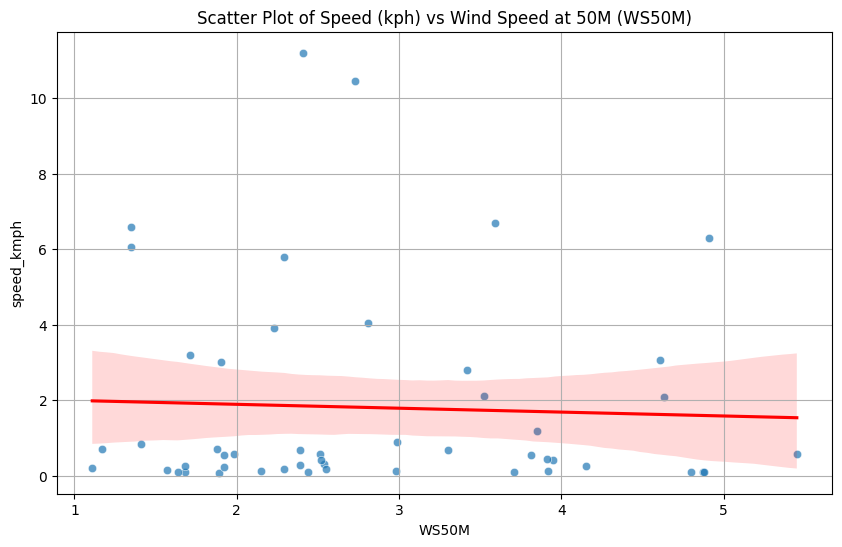

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create the DataFrame
data = pd.read_excel("./out/bird_speed_corr.xlsx")

df = pd.DataFrame(data)

# Remove outliers based on wind speed (WS50M column), using Z-score approximation
mean_wind_speed = df['WS50M'].mean()
std_wind_speed = df['WS50M'].std()
df = df[(df['WS50M'] >= mean_wind_speed - 2 * std_wind_speed) & 
        (df['WS50M'] <= mean_wind_speed + 2 * std_wind_speed)]

# Calculate Q2 (25th percentile) for `speed_kmph`
q2_speed = df['speed_kmph'].quantile(0.25)

# Define wind speed ranges (e.g., 1-1.5, 2-2.5) based on WS50M values
wind_speed_ranges = [(1, 1.5),(1.5 , 2),(2, 2.5),(2.5 , 3), (3, 3.5), (3.5 , 4),(4, 4.5), (4.5 , 5),(5, 5.5)]

# Create conditions for wind speed ranges in WS50M
conditions = [((df['WS50M'] >= low) & (df['WS50M'] <= high)) for low, high in wind_speed_ranges]
wind_speed_condition = np.logical_or.reduce(conditions)

# Sample rows where WS50M is within defined ranges and speed_kmph > Q2
sampled_df = df[wind_speed_condition & (df['speed_kmph'] > q2_speed)]

# Check the number of available samples
num_samples = len(sampled_df)
print(f"Number of available samples: {num_samples}")

# Get 10 random samples if available
if num_samples > 0:
    n_samples = min(50, num_samples)
    sampled_df = sampled_df.sample(n=n_samples, random_state=1)

    # Calculate correlation for the sampled DataFrame
    correlation = sampled_df[['speed_kmph', 'WS50M']].corr()
    
    # Display the correlation matrix
    print("Correlation matrix:")
    print(correlation)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=sampled_df, x='WS50M', y='speed_kmph', alpha=0.7)
    plt.title('Scatter Plot of Speed (kph) vs Wind Speed at 50M (WS50M)')
    plt.xlabel('Wind Speed at 50M (WS50M)')
    plt.ylabel('Speed (kph)')
    
    # Optional: Add a regression line
    sns.regplot(data=sampled_df, x='WS50M', y='speed_kmph', scatter=False, color='red')

    plt.grid()
    plt.show()
else:
    print("No valid samples available to sample from.")


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, month

# Step 1: Load the dataset
file_path = "./insights/bird_weather_data.xlsx"
df = pd.read_excel(file_path)

# List of required months
required_months = [3]  # Example: March

# Filter the DataFrame
df = df.filter(month(col("hourly_timestamp")).isin(required_months))

# Step 2: Remove outliers based on `windspeed`, using Z-score approximation
mean_wind_speed = df['windspeed'].mean()
std_wind_speed = df['windspeed'].std()
df = df[(df['windspeed'] >= mean_wind_speed - 2 * std_wind_speed) & 
        (df['windspeed'] <= mean_wind_speed + 2 * std_wind_speed)]

# Step 3: Calculate Q2 (25th percentile) for `speed_kmph`
q2_speed = df['speed_kmph'].quantile(0.25)

# Step 4: Define wind speed ranges for `windspeed` with increments of 1.0
wind_speed_ranges = [(i, i + 1) for i in range(1, 9)]  # Ranges from 1-2, 2-3, ..., 8-9

# Step 5: Create conditions for rows where `windspeed` is within the defined ranges
conditions = [((df['windspeed'] >= low) & (df['windspeed'] < high)) for low, high in wind_speed_ranges]
wind_speed_condition = np.logical_or.reduce(conditions)

# Step 6: Filter rows where `windspeed` is in range and `speed_kmph > Q2`
sampled_df = df[wind_speed_condition & (df['speed_kmph'] > q2_speed)]

# Step 7: Check the number of available samples
num_samples = len(sampled_df)
print(f"Number of available samples: {num_samples}")

# Step 8: Get up to 50 random samples if available
if num_samples > 0:
    n_samples = min(100, num_samples)  # Choose up to 50 samples
    sampled_df = sampled_df.sample(n=n_samples, random_state=42)

    # Calculate correlation for the sampled DataFrame (speed_kmph and windspeed only)
    correlation = sampled_df[['speed_kmph', 'windspeed']].corr()
    
    # Display the correlation matrix
    print("Correlation matrix:")
    print(correlation)
    
    # Step 9: Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=sampled_df, x='windspeed', y='speed_kmph', alpha=0.7)
    plt.title('Scatter Plot of Speed (kph) vs Wind Speed')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Speed (kph)')
    
    # Optional: Add a regression line
    sns.regplot(data=sampled_df, x='windspeed', y='speed_kmph', scatter=False, color='red')

    plt.grid()
    plt.show()
else:
    print("No valid samples available to sample from.")


AssertionError: 